<a href="https://colab.research.google.com/github/DjordjeRadovanovic/PPPO_Projekat_IT39_2020/blob/main/PPPO_Projekat_IT39_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Principi prezentacije i prepoznavanja oblika 2023/2024**


**Đorđe Radovanović IT39/2020**

**Tema:** Klasifikacija lišća

## **Sadržaj**

1. Uvod
2. Tema
3. Učitavanje dataseta
4. Projekat
5. Zaključak
6. Literatura

## **1. Uvod**

## **2. Metodologija**

## **3. Učitavanje dataseta**

Prvi korak je učitavanje seta podataka koji će se koristiti prilikom treniranja modela. Da bi se to uradilo, neophodno je skinuti .zip fajl koji sadrži sve potrebne podatke, pomoću **wget** komande.

In [5]:
!wget --no-check-certificate 'https://drive.usercontent.google.com/download?id=1r4yy2ZIUGoyESydQzY39L-0s8ld7fuXr&confirm=xxx' -O Leaf_Classification.zip

--2024-06-16 20:27:57--  https://drive.usercontent.google.com/download?id=1r4yy2ZIUGoyESydQzY39L-0s8ld7fuXr&confirm=xxx
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.134.132, 2607:f8b0:400c:c00::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.134.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35953027 (34M) [application/octet-stream]
Saving to: ‘Leaf_Classification.zip’

Leaf_Classification 100%[===================>]  34.29M  64.9MB/s    in 0.5s    

2024-06-16 20:27:58 (64.9 MB/s) - ‘Leaf_Classification.zip’ saved [35953027/35953027]



Kada je Leaf_Classification.zip fajl skinut, potrebno je izvršiti dekompresiju podataka. To radimo pomoću **unzip** komande.

In [6]:
!unzip Leaf_Classification.zip

Archive:  Leaf_Classification.zip
replace images.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Možemo uočiti da se u Leaf_Classification.zip fajlu nalaze još 4 posebna .zip fajla: *images.zip*, *sample_submission.csv.zip*, *train.csv.zip* i *test.csv.zip*. Analizom sadržaja ovih fajlova utvrđeno je da neće trebati *sample_submission.csv.zip*. Stoga, ponovićemo **unzip**, ali samo za ostala tri .zip fajla.

In [7]:
!unzip -qq images.zip
!unzip -qq train.csv.zip
!unzip -qq test.csv.zip

replace images/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace images/10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace images/100.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Sada imamo sve podatke raspakovane i spremne za korišćenje u daljem radu. Sledeći korak je pisanje samog koda za pripremu podataka, generisanje, treniranje i testiranje modela.

## **4. Projekat**

Prva stvar koju je potrebno uraditi je importovanje svih neophodnih biblioteka za projekat. Potrebno je koristiti **pandas** biblioteku za Python, koja ima DataFrame dvodimenzionalnu strukturu podataka koju možemo koristiti za predstavljanje tabelarnih CSV podataka. Takođe je potrebno koristiti **NumPy** biblioteku za matematičke operacije nad prosleđenim podacima.

VGG16 model možemo preuzeti iz **Keras** biblioteke, koja se koristi u svrhe mašinskog učenja. **Keras** biblioteka sadrži veliki broj modela, uključujuči i VGG16, koji će se koristiti. **Keras** koristi TensorFlow backend.

In [ ]:
# Importovanje neophodnih biblioteka
import keras
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

Sledeći korak je učitavanje i sređivanje CSV podataka iz train.csv fajla. Učitavanje se vrši pomoću read_csv funkcije iz pandas paketa.

In [ ]:
# Učitavanje podataka iz train.csv u train_data DataFrame
train_data = pd.read_csv('train.csv')

# Prikazivanje svih kolona
train_data.columns

Index(['id', 'species', 'margin1', 'margin2', 'margin3', 'margin4', 'margin5',
       'margin6', 'margin7', 'margin8',
       ...
       'texture55', 'texture56', 'texture57', 'texture58', 'texture59',
       'texture60', 'texture61', 'texture62', 'texture63', 'texture64'],
      dtype='object', length=194)

Vidimo da ima veliki broj kolona - marginX kolone, shapeX kolone, textureX kolone. Kako nisu potrebne za ovaj projekat, možemo ih izbaciti.

In [ ]:
# Brisanje nepotrebnih kolona
i = 1
while i <= 64:
  del train_data['margin' + str(i)]
  del train_data['shape' + str(i)]
  del train_data['texture' + str(i)]
  i = i + 1

# Prikazivanje svih kolona
train_data.columns

Index(['id', 'species'], dtype='object')

Sada imamo samo dve kolone, **id** (koja predstavlja sliku u /images, poput 1.png), i **species** (klasa datog lista sa slike). Poslednja stvar koju treba odraditi je brisanje redova sa null vrednostima, ukoliko ih ima.

In [ ]:
# Broj redova pre brisanja null vrednosti
print(train_data.shape[0])

# Brisanje redova sa null vrednostima
train_data.dropna()

# Broj redova nakon brisanja null vrednosti
print(train_data.shape[0])

990
990


Sada možemo dodati slike u train_data dataframe. To možemo obaviti kreiranjem nove kolone gde slika u koloni odgovara ID-ju ("1 -> images/1.jpg"). Potrebno je koristiti funkcije za manipulaciju slikama iz **Python Image Library** (**PIL**) biblioteke.

**VGG16** zahteva upotrebu 224x224 slika, pa se slike već u ovom koraku mogu prilagoditi datom formatu.

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
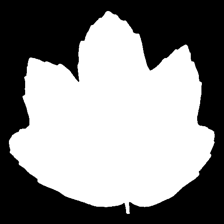

In [ ]:
# Pretvaranje slike u NumPy array
def image_column(id):
  img = Image.open(f'images/{id}.jpg')
  img = img.resize((224, 224))          # 224x224 dimenzije
  return np.asarray(img)

# Dodavanje nove kolone sa slikom koja odgovara koloni 'id'
train_data['img'] = train_data['id'].apply(image_column)

# Primer slike
train_data['img'][0]

Podaci su sada u formatu koji je potreban za treniranje **VGG16** modela. Ostalo je da ih podelimo na dva dela, na podatke za treniranje i podatke za validaciju (kako bismo utvrdili da model ima odgovarajuću tačnost predikcije klasifikacije).

Podelu vršimo putem **train_test_split** funkcije iz biblioteke **sklearn**.

In [ ]:
# Podela na podatke za treniranje i podatke za validaciju (odnos 80:20)
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42)

Sada imamo potpuno spremne dataframe-ove koje ćemo koristiti za treniranje i validaciju modela. Možemo uraditi sličan postupak za podatke koji će se koristiti za predikciju/testiranje modela.

In [ ]:
# Učitavanje podataka iz test.csv u test_df DataFrame
test_df = pd.read_csv('test.csv')

# Brisanje nepotrebnih kolona
i = 1
while i <= 64:
  del test_df['margin' + str(i)]
  del test_df['shape' + str(i)]
  del test_df['texture' + str(i)]
  i = i + 1

# Dodavanje nove kolone sa slikom koja odgovara koloni 'id'
test_df['img'] = test_df['id'].apply(image_column)

test_df

,id,img
0,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,12,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,13,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...
589,1576,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
590,1577,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
591,1579,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
592,1580,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


Sada smo dobili tri vrste podataka:

* **train_df** - Podaci za treniranje modela
* **val_df** - Podaci za validaciju modela
* **test_df** - Podaci za testiranje modela

Nakon sređivanja i čišćenja podataka, sledeći korak je priprema **VGG16** modela.

In [1]:
# Importovanje neophodnih biblioteka
import keras
import pandas as pd
import numpy as np
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
#from keras.applications.vgg16 import preprocess_input
#from keras.preprocessing import image
import os
from PIL import Image
import matplotlib.pyplot as plt

# Učitavanje podataka iz train.csv u train_df DataFrame
train_df = pd.read_csv('train.csv')

# Definisanje direktorijuma sa slikama
img_dir = 'images/'

# Učitavanje i predprocesiranje slika
def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img_array = np.asarray(img)
    img_array = img_array / 255.0
    return img_array

# Kreiranje listi sa podacima za treniranje modela
x_train = []
y_train = []

# Popunjavanje x_train i y_train listi
for index, row in train_df.iterrows():
    id = row['id']
    species = row['species']
    img_path = os.path.join(img_dir, f'{id}.jpg')

    # Učitavanje i sređivanje slike
    img = load_and_preprocess_image(img_path)

    # Dodavanje slike u x_train listu
    x_train.append(img)

    # Dodavanje klase u y_train listu
    y_train.append(species)

# Provera x_train i y_train
print('x_train[0] shape:', x_train[0].shape)
print('y_train[0]:', y_train[0])

x_new = []
for image in x_train:
    img_array = np.asarray(image)
    x_new.append(img_array)
x_train = np.array(x_new)

# Konverzija x_train u odgovarajući oblik - iz (990, 224, 224) u (990, 224, 224, 3)
x_train = np.repeat(x_train[..., np.newaxis], 3, axis=-1)

# Transformacija labela u numeričke vrednosti, za output
classes = y_train   #Da bismo sačuvali nazive klasa
y_train = LabelEncoder().fit_transform(y_train)
y_train = np.array(y_train)

# Prikaz oblika x_train i y_train
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

# Dobijanje ukupnog broja klasa
num_classes = train_df['species'].unique().size
print('Broj klasa: ', num_classes)

########################################################################

# Konfiguracija VGG16
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Onemogućavanje treniranja slojeva VGG16 modela
for layer in vgg_conv.layers[:-2]:
    layer.trainable = False

for layer in vgg_conv.layers:
    print(layer, layer.trainable)

# Kreiranje modela - sekvencijalni
model = keras.Sequential()

# Dodavanje VGG16 slojeva u model
model.add(vgg_conv)

# Dodavanje novih slojeva u model
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Prikazivanje podataka o modelu koji je kreiran
model.summary()

# Kompilacija modela
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Treniranje modela
history = model.fit(x_train, y_train, epochs=15, validation_split=0.2, batch_size=32)

# Čuvanje modela
#model.save('model.keras')

# Krive tačnosti i gubitaka
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Prikaz tačnosti treninga i validacije
# Prikaz gubitka treninga i validacije

plt.figure(figsize=(20,10))
plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.05, hspace=0)
plt.subplot(121)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy', size=20)
plt.legend(prop={'size': 10})
plt.grid()
plt.subplot(122)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.legend(prop={'size': 10})
plt.grid()
plt.show()

########################################################################

# Učitavanje podataka iz test.csv u test_df DataFrame
test_df = pd.read_csv('test.csv')

# Kreiranje x_test podataka za predikciju
x_test = []

# Popunjavanje x_test liste
for index, row in test_df.iterrows():
    id = int(row['id'])                               # bugfix
    img_path = os.path.join(img_dir, f'{id}.jpg')
    img = load_and_preprocess_image(img_path)
    x_test.append(img)

x_new = []
for image in x_test:
    img_array = np.asarray(image)
    x_new.append(img_array)
x_test = np.array(x_new)

# Konverzija x_test u odgovarajući oblik - iz (594, 224, 224) u (594, 224, 224, 3)
x_test = np.repeat(x_test[..., np.newaxis], 3, axis=-1)

# Prikaz oblika x_test
print('x_test shape:', x_test.shape)

# Klasifikacija novih slika
y_test = model.predict(x_test)

x_train[0] shape: (224, 224)
y_train[0]: Acer_Opalus
x_train shape: (990, 224, 224, 3)
y_train shape: (990,)
Broj klasa:  99
58889256/58889256 [==============================] - 0s 0us/step
<keras.src.engine.input_layer.InputLayer object at 0x7c1466e0f220> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c1466700220> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c14667009a0> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7c14667017b0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c1466701f90> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c14667026e0> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7c14667027a0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c1466703f70> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c1466701b40> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c1465ddcfa0> False
<keras.src.layers.poo

KeyboardInterrupt: 

In [4]:
# Verovatnoće klasa za prvu test sliku
print(y_test[0])

# Prva test slika
plt.imshow(x_test[0])
plt.title(np.argmax(y_test[0]))
plt.axis('off')

NameError: name 'y_test' is not defined

## **5. Zaključak**

## **6. Literatura**